**README**   
This program is used to evaluate yolo models after being trained using darknet

In [ ]:
#@title connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title import some basic libraries and create variables for future use
import os, json, ntpath, time, re
from shutil import copyfile

def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]

def print_time(log):
  current_time = time.strftime("%H:%M:%S", time.localtime())
  print(current_time+": "+log)

#@markdown path to LISA directory
LISA_path = "/content/drive/MyDrive/thesis/LISA dataset/" #@param {type:"string"}
#@markdown path where Detectron2 directory will be made
COCO_path = "/content/drive/MyDrive/thesis/COCO" #@param {type:"string"}
#@markdown path where Darknet directory will be made
YOLO_path = "/content/drive/MyDrive/thesis/YOLO/dataset" #@param {type:"string"}
#@markdown path where videos for getting FPS are stored
VIDEO_path = "/content/drive/MyDrive/thesis/VIDEOS" #@param {type:"string"}


print_time("creating model path")

#function to create path to model model weight path
def getModel(num):
  mnum = (str)(num)
  return os.path.join(YOLO_path,'backup','model'+(str)(mnum))

#@markdown set model path based on model number
model_num =  6 #@param {type:"number"}
model_path = getModel(model_num)


#@markdown Will create model folder and subfolders if they don't already exist
weight_path = os.path.join(model_path, 'weights')
cfg_path = os.path.join(model_path, 'cfg')
eval_path = os.path.join(model_path, 'eval')

print_time("creating folders for model if they don't already exist")
for x in [model_path, weight_path, cfg_path, eval_path]:
  if not os.exists(x):
    print_time("making folder " +ntpath.basename(x))
  os.makedirs(x, exist_ok=True)


print_time("finished setup of variables and imports")


15:07:58: creating model path
15:07:58: finished setup of variables and imports


In [ ]:
#@title update env variable for compilation
# Change the number depending on what GPU is listed above, under NVIDIA-SMI > Name.
# Tesla K80: 30
# Tesla P100: 60
# Tesla V100: 70
# Tesla T4: 75
import os
os.environ['GPU_TYPE'] = str(os.popen('nvidia-smi --query-gpu=name --format=csv,noheader').read())

def getGPUArch(argument):
  try:
    argument = argument.strip()
    # All Colab GPUs
    archTypes = {
        "Tesla V100-SXM2-16GB": "-gencode arch=compute_70,code=[sm_70,compute_70]",
        "Tesla K80": "-gencode arch=compute_37,code=sm_37",
        "Tesla T4": "-gencode arch=compute_75,code=[sm_75,compute_75]",
        "Tesla P40": "-gencode arch=compute_61,code=sm_61",
        "Tesla P4": "-gencode arch=compute_61,code=sm_61",
        "Tesla P100-PCIE-16GB": "-gencode arch=compute_60,code=sm_60"

      }
    return archTypes[argument]
  except KeyError:
    return "GPU must be added to GPU Commands"
os.environ['ARCH_VALUE'] = getGPUArch(os.environ['GPU_TYPE'])

print("GPU Type: " + os.environ['GPU_TYPE'])
print("ARCH Value: " + os.environ['ARCH_VALUE'])

arch_value = os.environ['ARCH_VALUE']

def getEnv(inp):
  archTypes = {
    "Tesla V100-SXM2-16GB":70,
    "Tesla K80": 30,
    "Tesla T4": 75,
    "Tesla P40": 61,
    "Tesla P4": 61,
    "Tesla P100-PCIE-16GB": 60

  }
  return archTypes[inp.strip('\n')]

environment=os.environ['GPU_TYPE']
envinum=getEnv(environment)
%env compute_capability=$envinum

GPU Type: Tesla P100-PCIE-16GB

ARCH Value: -gencode arch=compute_60,code=sm_60
env: compute_capability=60


In [ ]:
#@title clone yolo darknet
!git clone https://github.com/roboflow-ai/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 13289, done.
remote: Total 13289 (delta 0), reused 0 (delta 0), pack-reused 13289
Receiving objects: 100% (13289/13289), 12.13 MiB | 19.99 MiB/s, done.
Resolving deltas: 100% (9104/9104), done.


In [ ]:
#@title remove Makefile
%cd /content/darknet/
%rm Makefile

/content/darknet


In [ ]:
#@title Create Makefile
#colab occasionally shifts dependencies around, at the time of authorship, this Makefile works for building Darknet on Colab

%%writefile Makefile
GPU=1
CUDNN=1
CUDNN_HALF=0
OPENCV=1
AVX=0
OPENMP=0
LIBSO=1
ZED_CAMERA=0
ZED_CAMERA_v2_8=0

# set GPU=1 and CUDNN=1 to speedup on GPU
# set CUDNN_HALF=1 to further speedup 3 x times (Mixed-precision on Tensor Cores) GPU: Volta, Xavier, Turing and higher
# set AVX=1 and OPENMP=1 to speedup on CPU (if error occurs then set AVX=0)
# set ZED_CAMERA=1 to enable ZED SDK 3.0 and above
# set ZED_CAMERA_v2_8=1 to enable ZED SDK 2.X

USE_CPP=0
DEBUG=0

ARCH= -gencode arch=compute_35,code=sm_35 \
      -gencode arch=compute_50,code=[sm_50,compute_50] \
      -gencode arch=compute_52,code=[sm_52,compute_52] \
	    -gencode arch=compute_61,code=[sm_61,compute_61] \
      -gencode arch=compute_37,code=sm_37

ARCH= -gencode arch=compute_60,code=sm_60

OS := $(shell uname)

VPATH=./src/
EXEC=darknet
OBJDIR=./obj/

ifeq ($(LIBSO), 1)
LIBNAMESO=libdarknet.so
APPNAMESO=uselib
endif

ifeq ($(USE_CPP), 1)
CC=g++
else
CC=gcc
endif

CPP=g++ -std=c++11
NVCC=nvcc
OPTS=-Ofast
LDFLAGS= -lm -pthread
COMMON= -Iinclude/ -I3rdparty/stb/include
CFLAGS=-Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC

ifeq ($(DEBUG), 1)
#OPTS= -O0 -g
#OPTS= -Og -g
COMMON+= -DDEBUG
CFLAGS+= -DDEBUG
else
ifeq ($(AVX), 1)
CFLAGS+= -ffp-contract=fast -mavx -mavx2 -msse3 -msse4.1 -msse4.2 -msse4a
endif
endif

CFLAGS+=$(OPTS)

ifneq (,$(findstring MSYS_NT,$(OS)))
LDFLAGS+=-lws2_32
endif

ifeq ($(OPENCV), 1)
COMMON+= -DOPENCV
CFLAGS+= -DOPENCV
LDFLAGS+= `pkg-config --libs opencv4 2> /dev/null || pkg-config --libs opencv`
COMMON+= `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv`
endif

ifeq ($(OPENMP), 1)
CFLAGS+= -fopenmp
LDFLAGS+= -lgomp
endif

ifeq ($(GPU), 1)
COMMON+= -DGPU -I/usr/local/cuda/include/
CFLAGS+= -DGPU
ifeq ($(OS),Darwin) #MAC
LDFLAGS+= -L/usr/local/cuda/lib -lcuda -lcudart -lcublas -lcurand
else
LDFLAGS+= -L/usr/local/cuda/lib64 -lcuda -lcudart -lcublas -lcurand
endif
endif

ifeq ($(CUDNN), 1)
COMMON+= -DCUDNN
ifeq ($(OS),Darwin) #MAC
CFLAGS+= -DCUDNN -I/usr/local/cuda/include
LDFLAGS+= -L/usr/local/cuda/lib -lcudnn
else
CFLAGS+= -DCUDNN -I/usr/local/cudnn/include
LDFLAGS+= -L/usr/local/cudnn/lib64 -lcudnn
endif
endif

ifeq ($(CUDNN_HALF), 1)
COMMON+= -DCUDNN_HALF
CFLAGS+= -DCUDNN_HALF
ARCH+= -gencode arch=compute_70,code=[sm_70,compute_70]
endif

ifeq ($(ZED_CAMERA), 1)
CFLAGS+= -DZED_STEREO -I/usr/local/zed/include
ifeq ($(ZED_CAMERA_v2_8), 1)
LDFLAGS+= -L/usr/local/zed/lib -lsl_core -lsl_input -lsl_zed
#-lstdc++ -D_GLIBCXX_USE_CXX11_ABI=0
else
LDFLAGS+= -L/usr/local/zed/lib -lsl_zed
#-lstdc++ -D_GLIBCXX_USE_CXX11_ABI=0
endif
endif

OBJ=image_opencv.o http_stream.o gemm.o utils.o dark_cuda.o convolutional_layer.o list.o image.o activations.o im2col.o col2im.o blas.o crop_layer.o dropout_layer.o maxpool_layer.o softmax_layer.o data.o matrix.o network.o connected_layer.o cost_layer.o parser.o option_list.o darknet.o detection_layer.o captcha.o route_layer.o writing.o box.o nightmare.o normalization_layer.o avgpool_layer.o coco.o dice.o yolo.o detector.o layer.o compare.o classifier.o local_layer.o swag.o shortcut_layer.o activation_layer.o rnn_layer.o gru_layer.o rnn.o rnn_vid.o crnn_layer.o demo.o tag.o cifar.o go.o batchnorm_layer.o art.o region_layer.o reorg_layer.o reorg_old_layer.o super.o voxel.o tree.o yolo_layer.o gaussian_yolo_layer.o upsample_layer.o lstm_layer.o conv_lstm_layer.o scale_channels_layer.o sam_layer.o
ifeq ($(GPU), 1)
LDFLAGS+= -lstdc++
OBJ+=convolutional_kernels.o activation_kernels.o im2col_kernels.o col2im_kernels.o blas_kernels.o crop_layer_kernels.o dropout_layer_kernels.o maxpool_layer_kernels.o network_kernels.o avgpool_layer_kernels.o
endif

OBJS = $(addprefix $(OBJDIR), $(OBJ))
DEPS = $(wildcard src/*.h) Makefile include/darknet.h

all: $(OBJDIR) backup results setchmod $(EXEC) $(LIBNAMESO) $(APPNAMESO)

ifeq ($(LIBSO), 1)
CFLAGS+= -fPIC

$(LIBNAMESO): $(OBJDIR) $(OBJS) include/yolo_v2_class.hpp src/yolo_v2_class.cpp
	$(CPP) -shared -std=c++11 -fvisibility=hidden -DLIB_EXPORTS $(COMMON) $(CFLAGS) $(OBJS) src/yolo_v2_class.cpp -o $@ $(LDFLAGS)

$(APPNAMESO): $(LIBNAMESO) include/yolo_v2_class.hpp src/yolo_console_dll.cpp
	$(CPP) -std=c++11 $(COMMON) $(CFLAGS) -o $@ src/yolo_console_dll.cpp $(LDFLAGS) -L ./ -l:$(LIBNAMESO)
endif

$(EXEC): $(OBJS)
	$(CPP) -std=c++11 $(COMMON) $(CFLAGS) $^ -o $@ $(LDFLAGS)

$(OBJDIR)%.o: %.c $(DEPS)
	$(CC) $(COMMON) $(CFLAGS) -c $< -o $@

$(OBJDIR)%.o: %.cpp $(DEPS)
	$(CPP) -std=c++11 $(COMMON) $(CFLAGS) -c $< -o $@

$(OBJDIR)%.o: %.cu $(DEPS)
	$(NVCC) $(ARCH) $(COMMON) --compiler-options "$(CFLAGS)" -c $< -o $@

$(OBJDIR):
	mkdir -p $(OBJDIR)
backup:
	mkdir -p backup
results:
	mkdir -p results
setchmod:
	chmod +x *.sh

.PHONY: clean

clean:
	rm -rf $(OBJS) $(EXEC) $(LIBNAMESO) $(APPNAMESO)

Writing Makefile


In [ ]:
#@title make clean
!make clean

rm -rf ./obj/image_opencv.o ./obj/http_stream.o ./obj/gemm.o ./obj/utils.o ./obj/dark_cuda.o ./obj/convolutional_layer.o ./obj/list.o ./obj/image.o ./obj/activations.o ./obj/im2col.o ./obj/col2im.o ./obj/blas.o ./obj/crop_layer.o ./obj/dropout_layer.o ./obj/maxpool_layer.o ./obj/softmax_layer.o ./obj/data.o ./obj/matrix.o ./obj/network.o ./obj/connected_layer.o ./obj/cost_layer.o ./obj/parser.o ./obj/option_list.o ./obj/darknet.o ./obj/detection_layer.o ./obj/captcha.o ./obj/route_layer.o ./obj/writing.o ./obj/box.o ./obj/nightmare.o ./obj/normalization_layer.o ./obj/avgpool_layer.o ./obj/coco.o ./obj/dice.o ./obj/yolo.o ./obj/detector.o ./obj/layer.o ./obj/compare.o ./obj/classifier.o ./obj/local_layer.o ./obj/swag.o ./obj/shortcut_layer.o ./obj/activation_layer.o ./obj/rnn_layer.o ./obj/gru_layer.o ./obj/rnn.o ./obj/rnn_vid.o ./obj/crnn_layer.o ./obj/demo.o ./obj/tag.o ./obj/cifar.o ./obj/go.o ./obj/batchnorm_layer.o ./obj/art.o ./obj/region_layer.o ./obj/reorg_layer.o ./obj/reorg_ol

In [ ]:
#@title make
#install environment from the Makefile
#if you are on Colab free, you may need to change the Makefile for the K80 GPU
#this goes for any GPU, you need to change the Makefile to inform darknet which GPU you are running on.
#note the Makefile above should work for you, if you need to tweak, try the below
!sed -i "s/ARCH= -gencode arch=compute_60,code=sm_60/ARCH= -gencode arch=compute_${compute_capability},code=sm_${compute_capability}/g" Makefile
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:910:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1391:14: warning: unused variable ‘buff’ [-Wunused-variable]
         char buff[100];
              ^~~~
./src/image_opencv.cpp:1367:9: warning: unused variable ‘it_tb_re

In [ ]:
#@title Create files for execution (Config and pointers to images)


print_time("start time")

train_path = os.path.join(YOLO_path, "train")
valid_path  = os.path.join(YOLO_path, "valid")

classnum = sum(1 for line in open(os.path.join(YOLO_path, "class.names")))


#Set up training file directories for custom dataset
print_time("copying training class name file")

%cp "$YOLO_path/class.names" data/obj.names
%mkdir data/obj

print_time("creating obj.data")
with open('data/obj.data', 'w') as out:
  out.write('classes = '+(str)(classnum)+'\n')
  out.write('train = data/train.txt\n')
  out.write('valid = data/valid.txt\n')
  out.write('names = data/obj.names\n')
  out.write('backup = '+os.path.join(model_path, 'weights')+'\n') 

#updated bc backup should be nonlocal due to limited session time of colab
x=open('data/obj.data', 'r')
print_time("obj.data:\n"+x.read())
x.close()

#write train file (just the image list)
print_time("creating train and valid image list text files")

with open('data/train.txt', 'w') as out:
  for img in [f for f in os.listdir(train_path) if f.endswith('png')]:
    out.write(os.path.join(train_path,img)+'\n')

print_time("finished writing file train.txt")

#write the valid file (just the image list)
with open('data/valid.txt', 'w') as out:
  for img in [f for f in os.listdir(valid_path) if f.endswith('png')]:
    out.write(os.path.join(valid_path,img)+'\n')

print_time("finished writing file valid.txt")

print_time("created train and valid text files")

20:34:33: start time
20:34:34: copying training class name file
20:34:34: creating obj.data
20:34:34: obj.data:
classes = 13
train = data/train.txt
valid = data/valid.txt
names = data/obj.names
backup = /content/drive/MyDrive/thesis/YOLO/dataset/backup/model7/weights

20:34:34: creating train and valid image list text files
20:35:14: created train and valid text files


YOLO cfg created based on Roboflow implementation in their colab project: [link](https://colab.research.google.com/drive/1mzL6WyY9BRx4xX476eQdhKDnd_eixBlG#scrollTo=GNVU7eu9CQj3)

In [ ]:
#@title write YOLO cfg file
#we build config dynamically based on number of classes
#we build iteratively from base config files. This is the same file shape as cfg/yolo-obj.cfg
def file_len(fname):
  with open(fname) as f:
    for i, l in enumerate(f):
      pass
  return i + 1

#res - resolution of input conv
#sub_batches - how many batches are trained this iteration
#max_batches - how many total batches are planned
def writeCFG(res, sub_batches, max_batches):
  num_classes = file_len('data/obj.names')
  print("writing config for a custom YOLOv4 detector detecting number of classes: " + str(num_classes))

  #Instructions from the darknet repo
  #change line max_batches to (classes*2000 but not less than number of training images, and not less than 6000), f.e. max_batches=6000 if you train for 3 classes
  #change line steps to 80% and 90% of max_batches, f.e. steps=4800,5400
  if os.path.exists('./cfg/custom-yolov4-detector.cfg'): os.remove('./cfg/custom-yolov4-detector.cfg')


  with open('./cfg/custom-yolov4-detector.cfg', 'a') as f:
    f.write('[net]' + '\n')
    f.write('batch=64' + '\n')
    #####smaller subdivisions help the GPU run faster. 12 is optimal, but you might need to change to 24,36,64####
    wh = str(res)
    f.write('subdivisions=24' + '\n')
    f.write('width='+wh + '\n')
    f.write('height='+wh + '\n')
    f.write('channels=3' + '\n')
    f.write('momentum=0.949' + '\n')
    f.write('decay=0.0005' + '\n')
    f.write('angle=0' + '\n')
    f.write('saturation = 1.5' + '\n')
    f.write('exposure = 1.5' + '\n')
    f.write('hue = .1' + '\n')
    f.write('\n')
    f.write('learning_rate=0.001' + '\n')
    f.write('burn_in=1000' + '\n')
    ######you can adjust up and down to change training time#####
    ##Darknet does iterations with batches, not epochs####
    # max_batches (or total number of iterations) is calculated using the number of classes * the iteration number. The iteration number is recomended to be at least 2000.
    #max_batches = 2000
    f.write('max_batches=' + str(sub_batches) + '\n')
    f.write('policy=steps' + '\n')
    steps1 = .8 * max_batches #_batches
    steps2 = .9 * max_batches #_batches
    f.write('steps='+str(steps1)+','+str(steps2) + '\n')

    #Instructions from the darknet repo
    #change line classes=80 to your number of objects in each of 3 [yolo]-layers:
    #change [filters=255] to filters=(classes + 5)x3 in the 3 [convolutional] before each [yolo] layer, keep in mind that it only has to be the last [convolutional] before each of the [yolo] layers.

    with open('cfg/yolov4-custom2.cfg', 'r') as f2:
      content = f2.readlines()
      for line in content:
        f.write(line)    
      num_filters = (num_classes + 5) * 3
      f.write('filters='+str(num_filters) + '\n')
      f.write('activation=linear')
      f.write('\n')
      f.write('\n')
      f.write('[yolo]' + '\n')
      f.write('mask = 0,1,2' + '\n')
      f.write('anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401' + '\n')
      f.write('classes=' + str(num_classes) + '\n')

    with open('cfg/yolov4-custom3.cfg', 'r') as f3:
      content = f3.readlines()
      for line in content:
        f.write(line)    
      num_filters = (num_classes + 5) * 3
      f.write('filters='+str(num_filters) + '\n')
      f.write('activation=linear')
      f.write('\n')
      f.write('\n')
      f.write('[yolo]' + '\n')
      f.write('mask = 3,4,5' + '\n')
      f.write('anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401' + '\n')
      f.write('classes=' + str(num_classes) + '\n')

    with open('cfg/yolov4-custom4.cfg', 'r') as f4:
      content = f4.readlines()
      for line in content:
        f.write(line)    
      num_filters = (num_classes + 5) * 3
      f.write('filters='+str(num_filters) + '\n')
      f.write('activation=linear')
      f.write('\n')
      f.write('\n')
      f.write('[yolo]' + '\n')
      f.write('mask = 6,7,8' + '\n')
      f.write('anchors = 12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401' + '\n')
      f.write('classes=' + str(num_classes) + '\n')
      
    with open('cfg/yolov4-custom5.cfg', 'r') as f5:
      content = f5.readlines()
      for line in content:
        f.write(line)

  print("file is written!")    


size = "512" #@param [416, 512]
#@markdown Colab has limits on session time, so it may be necessary to train in batches instead all at once. sub batches are the amount of batches to train this session.
sub_batches = 26000 #@param {type:"number"}
#@markdown max batches are the total amount of batches that the model is aiming to be trained on.
max_batches = 26000 #@param {type:"number"}
writeCFG(size, sub_batches, 26000)



writing config for a custom YOLOv4 detector detecting number of classes: 13
file is written!


In [ ]:
#@title imshow definition
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

In [ ]:
#@title copy labels
#coco.names is hardcoded somewhere in the detector
%cp data/obj.names data/coco.names

# evaluate ap[0.5:0.05:0.95]

In [ ]:
#@title get each AP from IOU_THRESH=0.5 to 0.95

weights=os.path.join(weight_path,"custom-yolov4-detector_final.weights")
iou_thresh = 0.5 #default ap50

out = os.path.join(eval_path,"w26k-ap-50-95.txt") #file to store all ap metrics
input = open(out, 'w')
input.close()

for i in range(50, 95+1, 5):
  iou_thresh = i/100
  !./darknet detector map data/obj.data cfg/custom-yolov4-detector.cfg {weights} -iou_thresh {iou_thresh} >> {out}

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 compute_capability = 600, cudnn_half = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   9 route  8 2 	                           ->  208 x 208 x 128 
  10 conv     64       1 x 1/ 1    208 x 20

In [ ]:
#@title get all the AP values from the log file and save results to text in comma seperated format
import re
text = open(out, 'r').read()
search = "\(mAP@0\.([56789][05])\) = .*,"
x = re.search(search,text)
map_val = 0
string="IOU_Thresh,AP_Value\n"
for x in re.compile(search).finditer(text):
  number = float(x.group()[12:-1])
  string += x.group()[7:9] + ",{0:06.2%}".format(number) +'\n'
  map_val += number
string+="0.50:0.05:0.95,{0:06.2%}".format(map_val/10)
print(string)

with open(os.path.join(eval_path, '26000-AP-values.csv'), 'w') as out:
  out.write(string)

IOU_Thresh,AP_Value
50,79.53%
55,79.53%
60,79.42%
65,79.39%
70,79.16%
75,77.32%
80,74.49%
85,65.28%
90,39.57%
95,05.96%
0.50:0.05:0.95,65.96%


#chart AP based on weight files
AP75 wasn't tracked during training so we can use the weight files to get an estimate of how the AP values changed during training.

In [ ]:
#@title get AP values based on weights

iou_thresh = 0.75 #@param

out = os.path.join(eval_path,"AP%d"%(iou_thresh*100)+"raw-chart-values.txt")
!touch {out}

for step in range(1, 27, 1):
  weights=os.path.join(weight_path,"custom-yolov4-detector_"+str(step)+"000.weights")
  !./darknet detector map data/obj.data cfg/custom-yolov4-detector.cfg {weights} -iou_thresh {iou_thresh} >> {out}

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 compute_capability = 700, cudnn_half = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    512 x 512 x   3 ->  512 x 512 x  32 0.453 BF
   1 conv     64       3 x 3/ 2    512 x 512 x  32 ->  256 x 256 x  64 2.416 BF
   2 conv     64       1 x 1/ 1    256 x 256 x  64 ->  256 x 256 x  64 0.537 BF
   3 route  1 		                           ->  256 x 256 x  64 
   4 conv     64       1 x 1/ 1    256 x 256 x  64 ->  256 x 256 x  64 0.537 BF
   5 conv     32       1 x 1/ 1    256 x 256 x  64 ->  256 x 256 x  32 0.268 BF
   6 conv     64       3 x 3/ 1    256 x 256 x  32 ->  256 x 256 x  64 2.416 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 256 x 256 x  64 0.004 BF
   8 conv     64       1 x 1/ 1    256 x 256 x  64 ->  256 x 256 x  64 0.537 BF
   9 route  8 2 	                           ->  256 x 256 x 128 
  10 conv     64       1 x 1/ 1    256 x 25

1000,24.61%
2000,76.43%
3000,84.64%
4000,87.93%
5000,85.89%
6000,86.11%
7000,85.29%
8000,84.68%
9000,84.23%
10000,84.56%
11000,83.78%
12000,83.35%
13000,81.58%
14000,82.64%
15000,80.20%
16000,80.75%
17000,79.30%
18000,79.57%
19000,77.24%
20000,78.66%
21000,77.55%
22000,76.68%
23000,77.25%
24000,77.04%
25000,77.50%
26000,76.69%

2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000


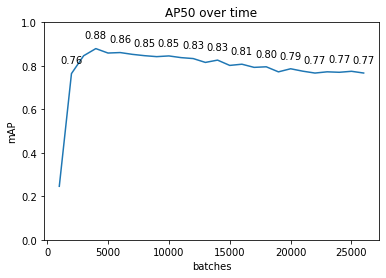

In [ ]:
#@title graph the results

ioustr = "%d"%(iou_thresh*100)

text = open(out, 'r').read()
search = "\(mAP@0\.([56789][05])\) = .*,"
x = re.search(search,text)
map_val = 0
string=""
iter = 1
x = []
y = []
for h in re.compile(search).finditer(text):
  number = float(h.group()[12:-1])
  x.append(iter*1000)
  y.append(number)
  string += str(iter*1000) + ",{0:06.2%}".format(number) +'\n'
  iter+=1
print(string)

import matplotlib.pyplot as plt
plt.plot(x,y,label="mAP")
plt.plot()
plt.xlabel("batches")
plt.ylabel("mAP")
plt.title("AP"+ioustr+" over time")

for xs,ys in zip(x,y):
  if xs % 2000 == 0:
    print(xs)
    label = "{:.2f}".format(ys)
    plt.annotate(label, # this is the text
                    (xs,ys), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

axes = plt.gca()
axes.set_ylim([0,1])
plt.savefig(os.path.join(eval_path,ioustr+'chart.png'))
plt.show()

with open(os.path.join(eval_path, ioustr+'chart.txt'), 'w') as out:
  out.write(string)

# test mAP

In [ ]:
#@title map single test

weights=os.path.join(model_path,"custom-yolov4-detector_26000.weights")
iou_thresh = 0.5

#out = os.path.join(model_path,"w26k-ap-"+"50-95"+".txt")
#input = open(out, 'w')
#input.close()
iou_thresh = 50/100
!./darknet detector map data/obj.data cfg/custom-yolov4-detector.cfg {weights} -iou_thresh {iou_thresh} -points 11

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 compute_capability = 600, cudnn_half = 0 
net.optimized_memory = 0 
mini_batch = 1, batch = 24, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    512 x 512 x   3 ->  512 x 512 x  32 0.453 BF
   1 conv     64       3 x 3/ 2    512 x 512 x  32 ->  256 x 256 x  64 2.416 BF
   2 conv     64       1 x 1/ 1    256 x 256 x  64 ->  256 x 256 x  64 0.537 BF
   3 route  1 		                           ->  256 x 256 x  64 
   4 conv     64       1 x 1/ 1    256 x 256 x  64 ->  256 x 256 x  64 0.537 BF
   5 conv     32       1 x 1/ 1    256 x 256 x  64 ->  256 x 256 x  32 0.268 BF
   6 conv     64       3 x 3/ 1    256 x 256 x  32 ->  256 x 256 x  64 2.416 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 256 x 256 x  64 0.004 BF
   8 conv     64       1 x 1/ 1    256 x 256 x  64 ->  256 x 256 x  64 0.537 BF
   9 route  8 2 	          

# create loss and AP50 graph from training log

log1.txt
log2.txt
log3.txt
log3.txt-time.txt
last total loss:0.08469
last AP50:0.766946


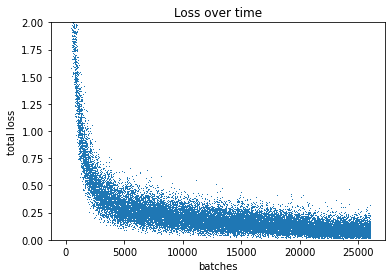

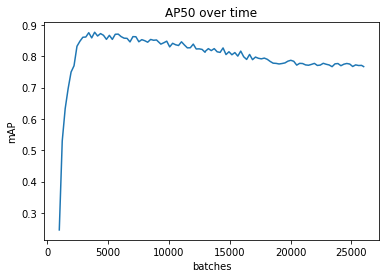

In [ ]:
import matplotlib.pyplot as plt

x = []
y =[]
apx = []
apy = []

def getPlotPoints():
  for line in searchLines:
    if "avg loss" in line:

      c1 = line.find(':')
      c2 = line.find(',', c1)
      c3 = line.find('avg loss', c2)
      
      x.append(int(line[:c1]))
      y.append(float(line[c1+1:c2]))

#      print(line[:c1] + ':' + line[c2+1:c3])
    
    if "mean average precision (mAP@" in line:
      apx.append(x[-1])
      apy.append( float(line[36:line.find(',', 36)]) )



#log files to search
files = [f for f in os.listdir(eval_path) if 'log' in f]
for f in files:
  print(f)
  out = os.path.join(eval_path,f)
  text = open(out, 'r')
  searchLines = text.readlines()
  text.close()
  getPlotPoints()



yx = zip(x,y)
yx_sorted = sorted(yx)
yx_sorted = zip(*yx_sorted)

x, y = [list(h) for h in yx_sorted]

#print final values
print("last total loss:"+str(y[-1]))
print("last AP50:"+str(apy[-1]))


plt.plot(x,y, ',')
plt.ylim(0, 2.0)
plt.xlabel("batches")
plt.ylabel("total loss")
plt.title("Loss over time")
plt.savefig(os.path.join(eval_path, 'Loss-train'))
plt.show()


plt.plot(apx, apy)
plt.xlabel("batches")
plt.ylabel("mAP")
plt.title("AP50 over time")
plt.savefig(os.path.join(eval_path, 'AP50-train'))
plt.show()
#with open(os.path.join(eval_path, 'chartAP.txt'), 'w') as out:
#  out.write(string)

In [ ]:
max(apy)

0.873079

# calculate average FPS

In [ ]:
video = os.path.join(VIDEO_path, "frametest2.mp4")
weights=os.path.join(weight_path,"custom-yolov4-detector_final.weights")
!./darknet detector demo data/obj.data cfg/custom-yolov4-detector.cfg $weights $video -benchmark

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
Demo
 compute_capability = 600, cudnn_half = 0 
net.optimized_memory = 0 
mini_batch = 1, batch = 24, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   9 route  8 2 	     